Coat-Lite-Medium with cutmix applied

Epoch 1/5: 100%|██████████| 225/225 [25:51<00:00,  6.89s/it]


Epoch 1: Train Acc: 64.69%, Val Acc: 95.60%


Epoch 2/5: 100%|██████████| 225/225 [25:22<00:00,  6.76s/it]


Epoch 2: Train Acc: 75.04%, Val Acc: 95.60%


Epoch 3/5: 100%|██████████| 225/225 [31:00<00:00,  8.27s/it]


Epoch 3: Train Acc: 77.73%, Val Acc: 96.80%


Epoch 4/5: 100%|██████████| 225/225 [31:38<00:00,  8.44s/it]


Epoch 4: Train Acc: 76.96%, Val Acc: 97.60%


Epoch 5/5: 100%|██████████| 225/225 [28:30<00:00,  7.60s/it]


Epoch 5: Train Acc: 75.80%, Val Acc: 96.80%


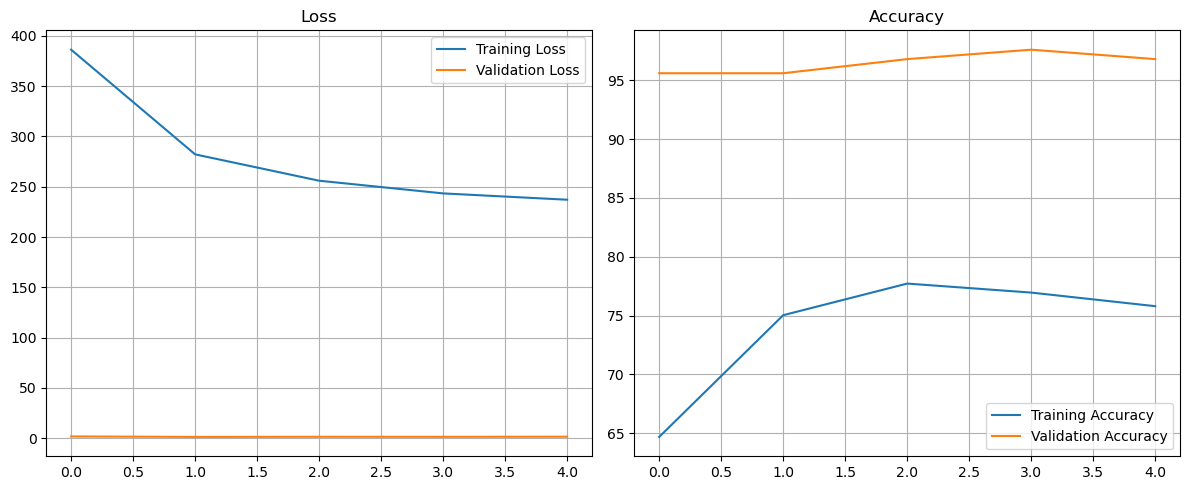

Test Accuracy: 99.20%
Classification Report:
                           precision    recall  f1-score   support

     ARCIGERA FLOWER MOTH       1.00      1.00      1.00         5
               ATLAS MOTH       1.00      1.00      1.00         5
        BANDED TIGER MOTH       1.00      1.00      1.00         5
  BIRD CHERRY ERMINE MOTH       1.00      1.00      1.00         5
        BLACK RUSTIC MOTH       1.00      1.00      1.00         5
             BLAIRS MOCHA       1.00      1.00      1.00         5
    BLOTCHED EMERALD MOTH       1.00      1.00      1.00         5
BLUE BORDERED CARPET MOTH       1.00      1.00      1.00         5
            CINNABAR MOTH       1.00      1.00      1.00         5
           CLEARWING MOTH       1.00      1.00      1.00         5
               COMET MOTH       1.00      1.00      1.00         5
    DEATHS HEAD HAWK MOTH       1.00      1.00      1.00         5
       ELEPHANT HAWK MOTH       1.00      1.00      1.00         5
         EMPEROR

In [20]:
# Import necessary libraries
from pathlib import Path
import os

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
from PIL import Image
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import transforms, datasets
from torchvision.transforms.v2 import CutMix  
from timm import create_model

# Device - tells PyTorch code to automatically select GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define Paths
data_root = Path("../data/kaggle-dataset/archive")

# Transforms - standard normalization used for ImageNet pretrained weights
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dictionary-style dataset and dataloader setup
data_transforms = {
    'train': transform,
    'valid': transform,
    'test': transform
}

image_datasets = {
    split: datasets.ImageFolder(os.path.join(data_root, split), transform=data_transforms[split])
    for split in ['train', 'valid', 'test']
}

class_names = image_datasets['train'].classes
num_classes = len(class_names)

# Apply cutmix data augmentation
cutmix = CutMix(num_classes=num_classes)

def cutmix_collate(batch):
    imgs, targets = zip(*batch)
    imgs = torch.stack(imgs)
    targets = torch.tensor(targets)
    imgs, targets = cutmix(imgs, targets)
    return imgs, targets

# Updated dataloader with CutMix for training only
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=32, shuffle=True, num_workers=0, collate_fn=cutmix_collate),
    'valid': DataLoader(image_datasets['valid'], batch_size=32, shuffle=False, num_workers=4),
    'test': DataLoader(image_datasets['test'], batch_size=32, shuffle=False, num_workers=4)
}

# Load CoaT-Lite Medium model with pretrained weights
model = create_model('coat_lite_medium', pretrained=True)

# Replace the final classification layer to match the number of different moth species
model.reset_classifier(num_classes)

# Freeze all layers first
for param in model.parameters():
    param.requires_grad = False

# Unfreeze only the last 2 blocks of serial_blocks4 + norm4 + head 
for name, param in model.named_parameters():
    if any([k in name for k in ["serial_blocks4.5", "serial_blocks4.6", "serial_blocks4.7", "norm4", "head"]]):
        param.requires_grad = True

model.to(device)

# Loss and optimizer for calculating error and adjusting for model improvement
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3, weight_decay=1e-4)

# Training
train_loss_list, val_loss_list = [], []
train_acc_list, val_acc_list = [], []
epochs = 5

for epoch in range(epochs):
    model.train()
    total_loss, total_correct, total_samples = 0, 0, 0

    for x, y in tqdm(dataloaders['train'], desc=f"Epoch {epoch+1}/{epochs}"):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_correct += (output.argmax(1) == y.argmax(1)).sum().item()
        total_samples += y.size(0)

    train_loss_list.append(total_loss)
    train_acc_list.append(100 * total_correct / total_samples)

    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for x, y in dataloaders['valid']:
            x, y = x.to(device), y.to(device)
            output = model(x)
            loss = criterion(output, y)
            val_loss += loss.item()
            val_correct += (output.argmax(1) == y).sum().item()
            val_total += y.size(0)

    val_loss_list.append(val_loss)
    val_acc_list.append(100 * val_correct / val_total)

    print(f"Epoch {epoch+1}: Train Acc: {train_acc_list[-1]:.2f}%, Val Acc: {val_acc_list[-1]:.2f}%")

# Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label="Training Loss")
plt.plot(val_loss_list, label="Validation Loss")
plt.legend()
plt.title("Loss")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label="Training Accuracy")
plt.plot(val_acc_list, label="Validation Accuracy")
plt.legend()
plt.title("Accuracy")
plt.grid(True)

plt.tight_layout()
plt.show()

# Test evaluation
model.eval()
all_preds, all_labels = [], []
test_correct, test_total = 0, 0

with torch.no_grad():
    for x, y in dataloaders['test']:
        x, y = x.to(device), y.to(device)
        output = model(x)
        pred = output.argmax(1)
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(y.cpu().numpy())
        test_correct += (pred == y).sum().item()
        test_total += y.size(0)

print(f"Test Accuracy: {100 * test_correct / test_total:.2f}%")
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Confused pairs
cm = confusion_matrix(all_labels, all_preds)
cm_copy = cm.copy()
np.fill_diagonal(cm_copy, 0)
confused = np.argwhere(cm_copy > 0)

print("Confused Class Pairs:")
for i, (true, pred) in enumerate(confused):
    count = cm[true, pred]
    print(f"{i+1}. True: {class_names[true]} ↔ Pred: {class_names[pred]} ({count} times)")

In [21]:
torch.save(model.state_dict(), "coat_lite_cutmix_only.pth")

Coat Lite Medium with cutmix and standard transformations applied:

Epoch 1/5: 100%|██████████| 225/225 [26:44<00:00,  7.13s/it]


Epoch 1: Train Acc: 63.52%, Val Acc: 96.40%


Epoch 2/5: 100%|██████████| 225/225 [17:44<00:00,  4.73s/it]


Epoch 2: Train Acc: 72.76%, Val Acc: 95.20%


Epoch 3/5: 100%|██████████| 225/225 [15:43<00:00,  4.19s/it]


Epoch 3: Train Acc: 76.53%, Val Acc: 94.40%


Epoch 4/5: 100%|██████████| 225/225 [15:47<00:00,  4.21s/it]


Epoch 4: Train Acc: 76.11%, Val Acc: 96.40%


Epoch 5/5: 100%|██████████| 225/225 [16:04<00:00,  4.29s/it]


Epoch 5: Train Acc: 78.52%, Val Acc: 97.20%


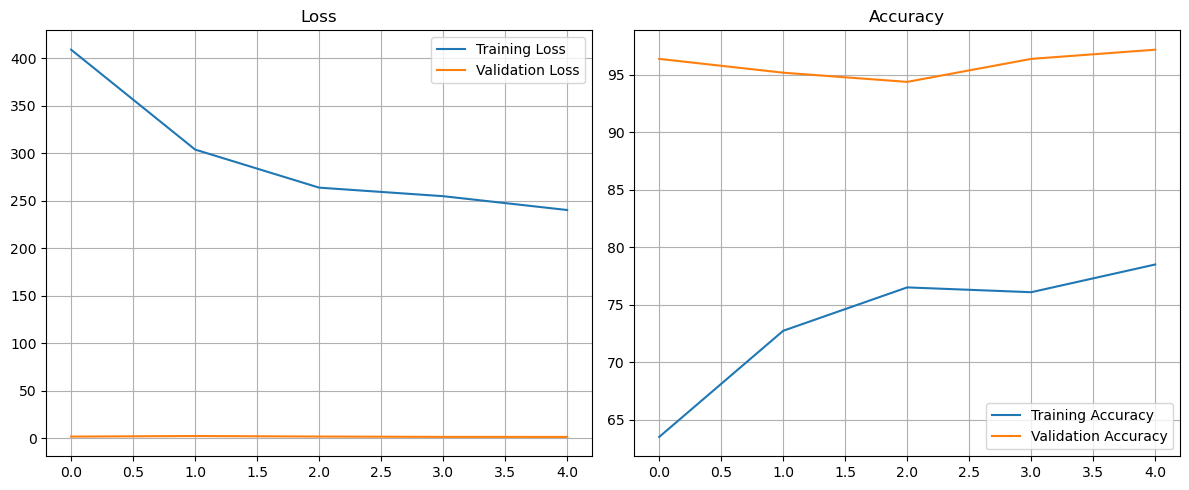

Test Accuracy: 98.80%
Classification Report:
                           precision    recall  f1-score   support

     ARCIGERA FLOWER MOTH       1.00      1.00      1.00         5
               ATLAS MOTH       1.00      1.00      1.00         5
        BANDED TIGER MOTH       1.00      1.00      1.00         5
  BIRD CHERRY ERMINE MOTH       1.00      1.00      1.00         5
        BLACK RUSTIC MOTH       1.00      1.00      1.00         5
             BLAIRS MOCHA       1.00      1.00      1.00         5
    BLOTCHED EMERALD MOTH       1.00      1.00      1.00         5
BLUE BORDERED CARPET MOTH       1.00      1.00      1.00         5
            CINNABAR MOTH       1.00      1.00      1.00         5
           CLEARWING MOTH       1.00      1.00      1.00         5
               COMET MOTH       1.00      1.00      1.00         5
    DEATHS HEAD HAWK MOTH       0.83      1.00      0.91         5
       ELEPHANT HAWK MOTH       1.00      1.00      1.00         5
         EMPEROR

In [25]:
# Import necessary libraries
from pathlib import Path
import os

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
from PIL import Image
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import transforms, datasets
from torchvision.transforms.v2 import CutMix  
from timm import create_model

# Device - tells PyTorch code to automatically select GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define Paths
data_root = Path("../data/kaggle-dataset/archive")

# Implement standard transformations including flips, rotations, and lighting simulation
# note: augmentations are for training only; consistent resizing + normalisation for val/test
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.15), ratio=(0.3, 3.3)) # Random erasing
])

transform_val_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Dictionary-style dataset and dataloader setup with custom transforms
data_transforms = {
    'train': transform_train,
    'valid': transform_val_test,
    'test': transform_val_test
}

image_datasets = {
    split: datasets.ImageFolder(os.path.join(data_root, split), transform=data_transforms[split])
    for split in ['train', 'valid', 'test']
}

class_names = image_datasets['train'].classes
num_classes = len(class_names)

# Apply cutmix data augmentation
cutmix = CutMix(num_classes=num_classes)

def cutmix_collate(batch):
    imgs, targets = zip(*batch)
    imgs = torch.stack(imgs)
    targets = torch.tensor(targets)
    imgs, targets = cutmix(imgs, targets)
    return imgs, targets

# Updated dataloader with CutMix for training only
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=32, shuffle=True, num_workers=0, collate_fn=cutmix_collate),
    'valid': DataLoader(image_datasets['valid'], batch_size=32, shuffle=False, num_workers=4),
    'test': DataLoader(image_datasets['test'], batch_size=32, shuffle=False, num_workers=4)
}

# Load CoaT-Lite Medium model with pretrained weights
model = create_model('coat_lite_medium', pretrained=True)

# Replace the final classification layer to match the number of different moth species
model.reset_classifier(num_classes)

# Freeze all layers first
for param in model.parameters():
    param.requires_grad = False

# Unfreeze only the last 2 blocks of serial_blocks4 + norm4 + head 
for name, param in model.named_parameters():
    if any([k in name for k in ["serial_blocks4.5", "serial_blocks4.6", "serial_blocks4.7", "norm4", "head"]]):
        param.requires_grad = True

model.to(device)

# Loss and optimizer for calculating error and adjusting for model improvement
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3, weight_decay=1e-4)

# Training
train_loss_list, val_loss_list = [], []
train_acc_list, val_acc_list = [], []
epochs = 5

for epoch in range(epochs):
    model.train()
    total_loss, total_correct, total_samples = 0, 0, 0

    for x, y in tqdm(dataloaders['train'], desc=f"Epoch {epoch+1}/{epochs}"):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_correct += (output.argmax(1) == y.argmax(1)).sum().item()
        total_samples += y.size(0)

    train_loss_list.append(total_loss)
    train_acc_list.append(100 * total_correct / total_samples)

    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for x, y in dataloaders['valid']:
            x, y = x.to(device), y.to(device)
            output = model(x)
            loss = criterion(output, y)
            val_loss += loss.item()
            val_correct += (output.argmax(1) == y).sum().item()
            val_total += y.size(0)

    val_loss_list.append(val_loss)
    val_acc_list.append(100 * val_correct / val_total)

    print(f"Epoch {epoch+1}: Train Acc: {train_acc_list[-1]:.2f}%, Val Acc: {val_acc_list[-1]:.2f}%")

# Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label="Training Loss")
plt.plot(val_loss_list, label="Validation Loss")
plt.legend()
plt.title("Loss")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label="Training Accuracy")
plt.plot(val_acc_list, label="Validation Accuracy")
plt.legend()
plt.title("Accuracy")
plt.grid(True)

plt.tight_layout()
plt.show()

# Test evaluation
model.eval()
all_preds, all_labels = [], []
test_correct, test_total = 0, 0

with torch.no_grad():
    for x, y in dataloaders['test']:
        x, y = x.to(device), y.to(device)
        output = model(x)
        pred = output.argmax(1)
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(y.cpu().numpy())
        test_correct += (pred == y).sum().item()
        test_total += y.size(0)

print(f"Test Accuracy: {100 * test_correct / test_total:.2f}%")
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Confused pairs
cm = confusion_matrix(all_labels, all_preds)
cm_copy = cm.copy()
np.fill_diagonal(cm_copy, 0)
confused = np.argwhere(cm_copy > 0)

print("Confused Class Pairs:")
for i, (true, pred) in enumerate(confused):
    count = cm[true, pred]
    print(f"{i+1}. True: {class_names[true]} ↔ Pred: {class_names[pred]} ({count} times)")

In [26]:
torch.save(model.state_dict(), "coat_lite_standard_augmentations.pth")

In [9]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
model = timm.create_model('coat_lite_medium', pretrained=False, num_classes=50)
model.load_state_dict(torch.load("coat_lite_cutmix_augmentation.pth", map_location=device))
model.to(device)
model.eval()

# Target Layer: final projection layer of last serial block
target_layers = [model.patch_embed4.proj]

# Load and preprocess image
image_path = "../data/kaggle-dataset/archive/test/CLEARWING MOTH/1.jpg"
image = Image.open(image_path).convert("RGB")
rgb_img = np.array(image.resize((224, 224))) / 255.0  

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
input_tensor = transform(image).unsqueeze(0).to(device)

# Initialise Score-CAM
cam = ScoreCAM(model=model, target_layers=target_layers)

# Generate CAM
grayscale_cam = cam(input_tensor=input_tensor)[0]
visualisation = show_cam_on_image(rgb_img.astype(np.float32), grayscale_cam, use_rgb=True)

output_path = Path("../cam_outputs/coat_lite_ft/score-cam-clearwing-1-cutmix-augmentation.jpg")
output_path.parent.mkdir(parents=True, exist_ok=True)
cv2.imwrite(str(output_path), visualisation)


100%|██████████| 32/32 [01:11<00:00,  2.23s/it]


True

Further transformations will be applied to the commonly confused species pairs

Epoch 1/5: 100%|██████████| 591/591 [1:29:30<00:00,  9.09s/it]


Epoch 1: Train Acc: 70.13%, Val Acc: 95.60%


Epoch 2/5: 100%|██████████| 591/591 [49:35<00:00,  5.03s/it] 


Epoch 2: Train Acc: 76.42%, Val Acc: 96.00%


Epoch 3/5: 100%|██████████| 591/591 [47:39<00:00,  4.84s/it]


Epoch 3: Train Acc: 77.60%, Val Acc: 96.00%


Epoch 4/5: 100%|██████████| 591/591 [46:51<00:00,  4.76s/it]


Epoch 4: Train Acc: 80.04%, Val Acc: 96.40%


Epoch 5/5: 100%|██████████| 591/591 [46:37<00:00,  4.73s/it]


Epoch 5: Train Acc: 79.38%, Val Acc: 95.60%


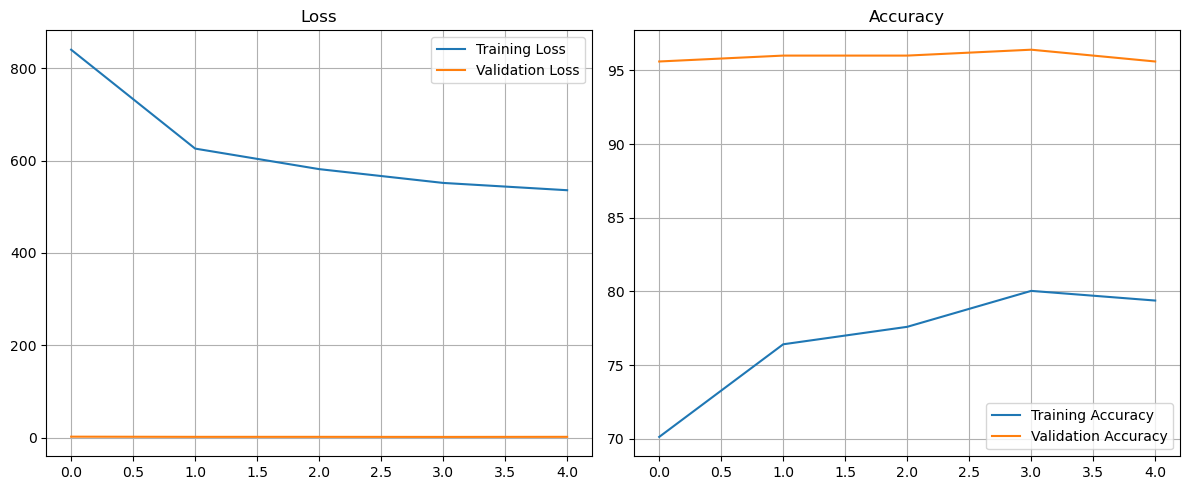

Test Accuracy: 97.20%
Classification Report:
                           precision    recall  f1-score   support

     ARCIGERA FLOWER MOTH       1.00      1.00      1.00         5
               ATLAS MOTH       1.00      1.00      1.00         5
        BANDED TIGER MOTH       1.00      1.00      1.00         5
  BIRD CHERRY ERMINE MOTH       0.62      1.00      0.77         5
        BLACK RUSTIC MOTH       1.00      1.00      1.00         5
             BLAIRS MOCHA       1.00      1.00      1.00         5
    BLOTCHED EMERALD MOTH       0.83      1.00      0.91         5
BLUE BORDERED CARPET MOTH       1.00      1.00      1.00         5
            CINNABAR MOTH       1.00      1.00      1.00         5
           CLEARWING MOTH       1.00      0.80      0.89         5
               COMET MOTH       1.00      1.00      1.00         5
    DEATHS HEAD HAWK MOTH       1.00      1.00      1.00         5
       ELEPHANT HAWK MOTH       1.00      1.00      1.00         5
         EMPEROR

In [27]:
# Import necessary libraries
from pathlib import Path
import os

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
from PIL import Image
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import transforms, datasets
from torchvision.transforms.v2 import CutMix  
from timm import create_model

# Device - tells PyTorch code to automatically select GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define Paths
data_root = Path("../data/targeted_augmented_dataset")

# Implement standard transformations including flips, rotations, and lighting simulation
# note: augmentations are for training only; consistent resizing + normalisation for val/test
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.15), ratio=(0.3, 3.3)) # Random erasing
])

transform_val_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Dictionary-style dataset and dataloader setup with custom transforms
data_transforms = {
    'train': transform_train,
    'valid': transform_val_test,
    'test': transform_val_test
}

image_datasets = {
    split: datasets.ImageFolder(os.path.join(data_root, split), transform=data_transforms[split])
    for split in ['train', 'valid', 'test']
}

class_names = image_datasets['train'].classes
num_classes = len(class_names)

# Apply cutmix data augmentation
cutmix = CutMix(num_classes=num_classes)

def cutmix_collate(batch):
    imgs, targets = zip(*batch)
    imgs = torch.stack(imgs)
    targets = torch.tensor(targets)
    imgs, targets = cutmix(imgs, targets)
    return imgs, targets

# Updated dataloader with CutMix for training only
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=32, shuffle=True, num_workers=0, collate_fn=cutmix_collate),
    'valid': DataLoader(image_datasets['valid'], batch_size=32, shuffle=False, num_workers=4),
    'test': DataLoader(image_datasets['test'], batch_size=32, shuffle=False, num_workers=4)
}

# Load CoaT-Lite Medium model with pretrained weights
model = create_model('coat_lite_medium', pretrained=True)

# Replace the final classification layer to match the number of different moth species
model.reset_classifier(num_classes)

# Freeze all layers first
for param in model.parameters():
    param.requires_grad = False

# Unfreeze only the last 2 blocks of serial_blocks4 + norm4 + head 
for name, param in model.named_parameters():
    if any([k in name for k in ["serial_blocks4.5", "serial_blocks4.6", "serial_blocks4.7", "norm4", "head"]]):
        param.requires_grad = True

model.to(device)

# Loss and optimizer for calculating error and adjusting for model improvement
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3, weight_decay=1e-4)

# Training
train_loss_list, val_loss_list = [], []
train_acc_list, val_acc_list = [], []
epochs = 5

for epoch in range(epochs):
    model.train()
    total_loss, total_correct, total_samples = 0, 0, 0

    for x, y in tqdm(dataloaders['train'], desc=f"Epoch {epoch+1}/{epochs}"):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_correct += (output.argmax(1) == y.argmax(1)).sum().item()
        total_samples += y.size(0)

    train_loss_list.append(total_loss)
    train_acc_list.append(100 * total_correct / total_samples)

    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for x, y in dataloaders['valid']:
            x, y = x.to(device), y.to(device)
            output = model(x)
            loss = criterion(output, y)
            val_loss += loss.item()
            val_correct += (output.argmax(1) == y).sum().item()
            val_total += y.size(0)

    val_loss_list.append(val_loss)
    val_acc_list.append(100 * val_correct / val_total)

    print(f"Epoch {epoch+1}: Train Acc: {train_acc_list[-1]:.2f}%, Val Acc: {val_acc_list[-1]:.2f}%")

# Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label="Training Loss")
plt.plot(val_loss_list, label="Validation Loss")
plt.legend()
plt.title("Loss")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label="Training Accuracy")
plt.plot(val_acc_list, label="Validation Accuracy")
plt.legend()
plt.title("Accuracy")
plt.grid(True)

plt.tight_layout()
plt.show()

# Test evaluation
model.eval()
all_preds, all_labels = [], []
test_correct, test_total = 0, 0

with torch.no_grad():
    for x, y in dataloaders['test']:
        x, y = x.to(device), y.to(device)
        output = model(x)
        pred = output.argmax(1)
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(y.cpu().numpy())
        test_correct += (pred == y).sum().item()
        test_total += y.size(0)

print(f"Test Accuracy: {100 * test_correct / test_total:.2f}%")
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Confused pairs
cm = confusion_matrix(all_labels, all_preds)
cm_copy = cm.copy()
np.fill_diagonal(cm_copy, 0)
confused = np.argwhere(cm_copy > 0)

print("Confused Class Pairs:")
for i, (true, pred) in enumerate(confused):
    count = cm[true, pred]
    print(f"{i+1}. True: {class_names[true]} ↔ Pred: {class_names[pred]} ({count} times)")

In [11]:
torch.save(model.state_dict(), "coat_lite_final_augmentations.pth")

Epoch 1/15: 100%|██████████| 394/394 [24:14<00:00,  3.69s/it]


Epoch 1: Train Acc: 76.10%, Val Acc: 91.60%


Epoch 2/15: 100%|██████████| 394/394 [34:10<00:00,  5.20s/it] 


Epoch 2: Train Acc: 86.91%, Val Acc: 96.00%


Epoch 3/15: 100%|██████████| 394/394 [27:21<00:00,  4.17s/it]


Epoch 3: Train Acc: 87.76%, Val Acc: 96.80%


Epoch 4/15: 100%|██████████| 394/394 [23:47<00:00,  3.62s/it]


Epoch 4: Train Acc: 88.78%, Val Acc: 92.00%


Epoch 5/15: 100%|██████████| 394/394 [22:26<00:00,  3.42s/it]


Epoch 5: Train Acc: 90.16%, Val Acc: 94.80%


Epoch 6/15: 100%|██████████| 394/394 [18:04<00:00,  2.75s/it]


Epoch 6: Train Acc: 90.48%, Val Acc: 95.20%


Epoch 7/15: 100%|██████████| 394/394 [18:10<00:00,  2.77s/it]


Epoch 7: Train Acc: 91.11%, Val Acc: 94.40%


Epoch 8/15: 100%|██████████| 394/394 [18:11<00:00,  2.77s/it]


Epoch 8: Train Acc: 91.24%, Val Acc: 94.40%
Early stopping triggered.


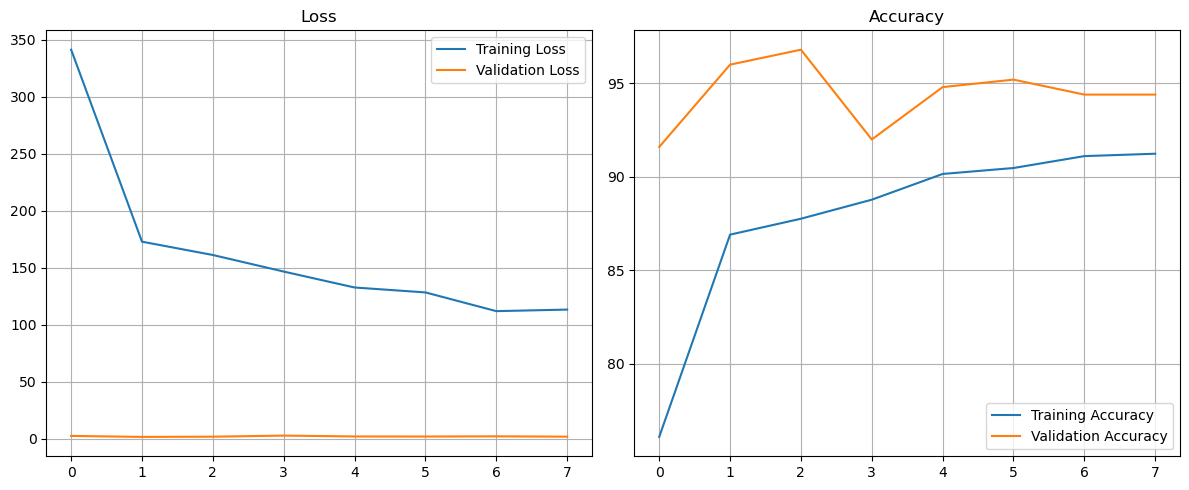

Test Accuracy: 96.80%
Classification Report:
                           precision    recall  f1-score   support

     ARCIGERA FLOWER MOTH       1.00      0.80      0.89         5
               ATLAS MOTH       1.00      1.00      1.00         5
        BANDED TIGER MOTH       0.80      0.80      0.80         5
  BIRD CHERRY ERMINE MOTH       1.00      1.00      1.00         5
        BLACK RUSTIC MOTH       1.00      1.00      1.00         5
             BLAIRS MOCHA       1.00      1.00      1.00         5
    BLOTCHED EMERALD MOTH       0.83      1.00      0.91         5
BLUE BORDERED CARPET MOTH       1.00      1.00      1.00         5
            CINNABAR MOTH       1.00      1.00      1.00         5
           CLEARWING MOTH       1.00      0.80      0.89         5
               COMET MOTH       1.00      1.00      1.00         5
    DEATHS HEAD HAWK MOTH       1.00      1.00      1.00         5
       ELEPHANT HAWK MOTH       1.00      1.00      1.00         5
         EMPEROR

In [16]:
# Import necessary programmes 
from pathlib import Path
import copy
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm

from torchvision import transforms, datasets
from torchvision.transforms.v2 import CutMix
from timm import create_model

# Set seed
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Paths
data_root = Path("../data/targeted_augmented_dataset")

# Transforms
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

transform_val_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Dataset and DataLoader
data_transforms = {
    'train': transform_train,
    'valid': transform_val_test,
    'test': transform_val_test
}

image_datasets = {
    split: datasets.ImageFolder(os.path.join(data_root, split), transform=data_transforms[split])
    for split in ['train', 'valid', 'test']
}

class_names = image_datasets['train'].classes
num_classes = len(class_names)

# Apply CutMix data augmentation
cutmix = CutMix(num_classes=num_classes)

def cutmix_collate(batch):
    imgs, targets = zip(*batch)
    imgs = torch.stack(imgs)
    targets = torch.tensor(targets)
    imgs, targets = cutmix(imgs, targets)
    return imgs, targets.argmax(dim=1)

# Dataloaders
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=32, shuffle=True, num_workers=0, collate_fn=cutmix_collate),
    'valid': DataLoader(image_datasets['valid'], batch_size=32, shuffle=False, num_workers=4),
    'test': DataLoader(image_datasets['test'], batch_size=32, shuffle=False, num_workers=4)
}

# Load Coat-Lite model
model = create_model('coat_lite_medium', pretrained=True)
model.reset_classifier(num_classes)

# Freeze all
for param in model.parameters():
    param.requires_grad = False

# Unfreeze serial_blocks4.5 and serial_blocks4.6, norm4, and head
for name, param in model.named_parameters():
    if any(k in name for k in ["serial_blocks4.5", "serial_blocks4.6", "norm4", "head"]):
        param.requires_grad = True

model.to(device)

# Discriminative learning rates
# Get all fine-tunable parameters
head_params = list(model.head.parameters())
norm_params = list(model.norm4.parameters())
block5_params = list(model.serial_blocks4[5].parameters())
block6_params = list(model.serial_blocks4[6].parameters())

# Track used parameter IDs to avoid duplicates
used_ids = set()

def filter_new(params):
    new_params = []
    for p in params:
        if id(p) not in used_ids:
            new_params.append(p)
            used_ids.add(id(p))
    return new_params

head_params = filter_new(head_params)
norm_params = filter_new(norm_params)
block5_params = filter_new(block5_params)
block6_params = filter_new(block6_params)

# Now param groups are guaranteed to be distinct
param_groups = [
    {'params': head_params, 'lr': 1e-3},
    {'params': norm_params + block5_params + block6_params, 'lr': 5e-4}
]

# Define optimiser and loss
optimizer = torch.optim.Adam(param_groups, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

num_epochs = 15
early_stopping_patience = 5

# Training 
train_loss_list, val_loss_list = [], []
train_acc_list, val_acc_list = [], []

best_val_acc = 0
epochs_no_improve = 0
early_stop = False
best_model_wts = copy.deepcopy(model.state_dict())

for epoch in range(num_epochs):
    model.train()
    total_loss, total_correct, total_samples = 0, 0, 0

    for x, y in tqdm(dataloaders['train'], desc=f"Epoch {epoch+1}/{num_epochs}"):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_correct += (output.argmax(1) == y).sum().item()
        total_samples += y.size(0)

    train_loss_list.append(total_loss)
    train_acc_list.append(100 * total_correct / total_samples)

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for x, y in dataloaders['valid']:
            x, y = x.to(device), y.to(device)
            output = model(x)
            loss = criterion(output, y)
            val_loss += loss.item()
            val_correct += (output.argmax(1) == y).sum().item()
            val_total += y.size(0)

    val_loss_list.append(val_loss)
    val_acc = 100 * val_correct / val_total
    val_acc_list.append(val_acc)
    
    print(f"Epoch {epoch+1}: Train Acc: {train_acc_list[-1]:.2f}%, Val Acc: {val_acc:.2f}%")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= early_stopping_patience:
        print("Early stopping triggered.")
        early_stop = True
        break

# Restore best weights
model.load_state_dict(best_model_wts)

# Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label="Training Loss")
plt.plot(val_loss_list, label="Validation Loss")
plt.legend()
plt.title("Loss")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label="Training Accuracy")
plt.plot(val_acc_list, label="Validation Accuracy")
plt.legend()
plt.title("Accuracy")
plt.grid(True)

plt.tight_layout()
plt.show()

# Test Evaluation
model.eval()
all_preds, all_labels = [], []
test_correct, test_total = 0, 0

with torch.no_grad():
    for x, y in dataloaders['test']:
        x, y = x.to(device), y.to(device)
        output = model(x)
        pred = output.argmax(1)
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(y.cpu().numpy())
        test_correct += (pred == y).sum().item()
        test_total += y.size(0)

print(f"Test Accuracy: {100 * test_correct / test_total:.2f}%")
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Confusion matrix + confused pairs
cm = confusion_matrix(all_labels, all_preds)
cm_copy = cm.copy()
np.fill_diagonal(cm_copy, 0)
confused = np.argwhere(cm_copy > 0)

print("Confused Class Pairs:")
for i, (true, pred) in enumerate(confused):
    count = cm[true, pred]
    print(f"{i+1}. True: {class_names[true]} ↔ Pred: {class_names[pred]} ({count} times)")


In [ ]:
torch.save(model.state_dict(), "coat_lite_final_finetuning.pth")

Epoch 1/15: 100%|██████████| 394/394 [55:40<00:00,  8.48s/it]  


Epoch 1: Train Acc: 73.21%, Val Acc: 90.40%


Epoch 2/15: 100%|██████████| 394/394 [56:56<00:00,  8.67s/it]  


Epoch 2: Train Acc: 85.34%, Val Acc: 96.40%


Epoch 3/15: 100%|██████████| 394/394 [33:14<00:00,  5.06s/it]


Epoch 3: Train Acc: 86.77%, Val Acc: 95.60%


Epoch 4/15: 100%|██████████| 394/394 [31:24<00:00,  4.78s/it]


Epoch 4: Train Acc: 87.90%, Val Acc: 94.00%


Epoch 5/15: 100%|██████████| 394/394 [31:10<00:00,  4.75s/it]


Epoch 5: Train Acc: 88.58%, Val Acc: 96.00%


Epoch 6/15: 100%|██████████| 394/394 [29:22<00:00,  4.47s/it]


Epoch 6: Train Acc: 89.37%, Val Acc: 95.20%


Epoch 7/15: 100%|██████████| 394/394 [25:26<00:00,  3.88s/it]


Epoch 7: Train Acc: 90.58%, Val Acc: 94.80%
Early stopping triggered.


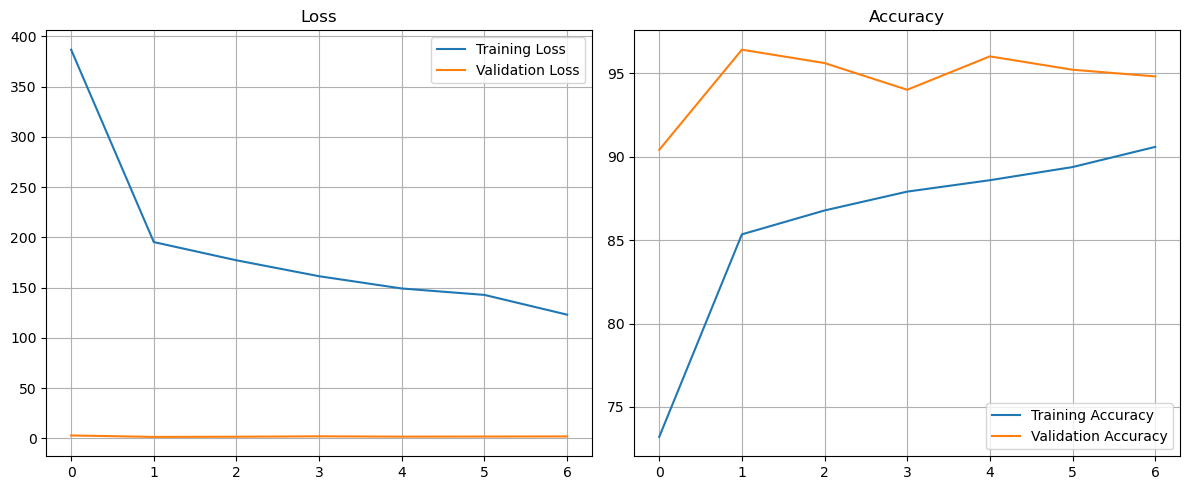

Test Accuracy: 97.60%
Classification Report:
                           precision    recall  f1-score   support

     ARCIGERA FLOWER MOTH       1.00      1.00      1.00         5
               ATLAS MOTH       1.00      1.00      1.00         5
        BANDED TIGER MOTH       1.00      1.00      1.00         5
  BIRD CHERRY ERMINE MOTH       1.00      1.00      1.00         5
        BLACK RUSTIC MOTH       1.00      1.00      1.00         5
             BLAIRS MOCHA       1.00      1.00      1.00         5
    BLOTCHED EMERALD MOTH       1.00      0.80      0.89         5
BLUE BORDERED CARPET MOTH       1.00      1.00      1.00         5
            CINNABAR MOTH       1.00      1.00      1.00         5
           CLEARWING MOTH       0.83      1.00      0.91         5
               COMET MOTH       1.00      1.00      1.00         5
    DEATHS HEAD HAWK MOTH       1.00      1.00      1.00         5
       ELEPHANT HAWK MOTH       1.00      1.00      1.00         5
         EMPEROR

In [17]:
# Import necessary programmes 
from pathlib import Path
import copy
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm

from torchvision import transforms, datasets
from torchvision.transforms.v2 import CutMix
from timm import create_model

# Set seed
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Paths
data_root = Path("../data/targeted_augmented_dataset")

# Transforms
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

transform_val_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Dataset and DataLoader
data_transforms = {
    'train': transform_train,
    'valid': transform_val_test,
    'test': transform_val_test
}

image_datasets = {
    split: datasets.ImageFolder(os.path.join(data_root, split), transform=data_transforms[split])
    for split in ['train', 'valid', 'test']
}

class_names = image_datasets['train'].classes
num_classes = len(class_names)

# Apply CutMix data augmentation
cutmix = CutMix(num_classes=num_classes)

def cutmix_collate(batch):
    imgs, targets = zip(*batch)
    imgs = torch.stack(imgs)
    targets = torch.tensor(targets)
    imgs, targets = cutmix(imgs, targets)
    return imgs, targets.argmax(dim=1)

# Dataloaders
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=32, shuffle=True, num_workers=0, collate_fn=cutmix_collate),
    'valid': DataLoader(image_datasets['valid'], batch_size=32, shuffle=False, num_workers=4),
    'test': DataLoader(image_datasets['test'], batch_size=32, shuffle=False, num_workers=4)
}

# Load Coat-Lite model
model = create_model('coat_lite_medium', pretrained=True)
model.reset_classifier(num_classes)

# Freeze all parameters
for param in model.parameters():
    param.requires_grad = False

# Unfreeze only head and serial_blocks4.6
for name, param in model.named_parameters():
    if any(k in name for k in ["serial_blocks4.6", "head"]):
        param.requires_grad = True

# Prepare discriminative parameter groups
head_params = list(model.head.parameters())
block6_params = list(model.serial_blocks4[6].parameters())

# Avoid parameter duplication
used_ids = set()
def filter_new(params):
    new = []
    for p in params:
        if id(p) not in used_ids:
            new.append(p)
            used_ids.add(id(p))
    return new

head_params = filter_new(head_params)
block6_params = filter_new(block6_params)

param_groups = [
    {'params': head_params, 'lr': 1e-3},
    {'params': block6_params, 'lr': 5e-4}
]

# Optimiser and criterion
optimizer = torch.optim.Adam(param_groups, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

num_epochs = 15
early_stopping_patience = 5

# Training 
train_loss_list, val_loss_list = [], []
train_acc_list, val_acc_list = [], []

best_val_acc = 0
epochs_no_improve = 0
early_stop = False
best_model_wts = copy.deepcopy(model.state_dict())

for epoch in range(num_epochs):
    model.train()
    total_loss, total_correct, total_samples = 0, 0, 0

    for x, y in tqdm(dataloaders['train'], desc=f"Epoch {epoch+1}/{num_epochs}"):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_correct += (output.argmax(1) == y).sum().item()
        total_samples += y.size(0)

    train_loss_list.append(total_loss)
    train_acc_list.append(100 * total_correct / total_samples)

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for x, y in dataloaders['valid']:
            x, y = x.to(device), y.to(device)
            output = model(x)
            loss = criterion(output, y)
            val_loss += loss.item()
            val_correct += (output.argmax(1) == y).sum().item()
            val_total += y.size(0)

    val_loss_list.append(val_loss)
    val_acc = 100 * val_correct / val_total
    val_acc_list.append(val_acc)
    
    print(f"Epoch {epoch+1}: Train Acc: {train_acc_list[-1]:.2f}%, Val Acc: {val_acc:.2f}%")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= early_stopping_patience:
        print("Early stopping triggered.")
        early_stop = True
        break

# Restore best weights
model.load_state_dict(best_model_wts)

# Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label="Training Loss")
plt.plot(val_loss_list, label="Validation Loss")
plt.legend()
plt.title("Loss")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label="Training Accuracy")
plt.plot(val_acc_list, label="Validation Accuracy")
plt.legend()
plt.title("Accuracy")
plt.grid(True)

plt.tight_layout()
plt.show()

# Test Evaluation
model.eval()
all_preds, all_labels = [], []
test_correct, test_total = 0, 0

with torch.no_grad():
    for x, y in dataloaders['test']:
        x, y = x.to(device), y.to(device)
        output = model(x)
        pred = output.argmax(1)
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(y.cpu().numpy())
        test_correct += (pred == y).sum().item()
        test_total += y.size(0)

print(f"Test Accuracy: {100 * test_correct / test_total:.2f}%")
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Confusion matrix + confused pairs
cm = confusion_matrix(all_labels, all_preds)
cm_copy = cm.copy()
np.fill_diagonal(cm_copy, 0)
confused = np.argwhere(cm_copy > 0)

print("Confused Class Pairs:")
for i, (true, pred) in enumerate(confused):
    count = cm[true, pred]
    print(f"{i+1}. True: {class_names[true]} ↔ Pred: {class_names[pred]} ({count} times)")


In [18]:
torch.save(model.state_dict(), "coat_lite_reduced_finetuning.pth")